DDPM Theory
====

---------------
Note:
 * This notation $p(x)=\mathcal{N}(x;a,b)$ means PDF (probability density function) of $x$ is a Gaussian with mean $a$ and standard-deviation $b$
 * This notation $x\sim \mathcal{N}(a, b)$ means x is sampled from a Gaussian distribution with mean $a$ and standard-deviation $b$

---------------


* Diffusion Process:
  * Forward process:
    - $q(x_t|x_{t-1})$

  * Reverse process: 
    - $q(x_{t-1}|x_{t})$  $\Rightarrow$ intractable
    - $p_\theta(x_{t-1}|x_{t})$

-----

* Forward process
$$q(x_t|x_{t-1})=\mathcal{N}\left(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t\mathbb{I}\right)$$


* Joint distribution of the forward process
$$q(x_{1..T}|x_0)=\prod_{t=1}^T q(x_t|x_{t-1})$$

* Simplified forward process (jump from $0$ to $t$):
$$q(x_t|x_0)=\mathcal{N}\left(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)\mathbb{I}\right)$$

 * Forward equation:
$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon$$

$\alpha_t = 1-\beta_i$


$\bar{\alpha}_t = \prod_{i=1}^t \alpha_t$

 * Linear noise scheduler:
   * $\beta_1=0.0001$
   * $\beta_T=0.02$


In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

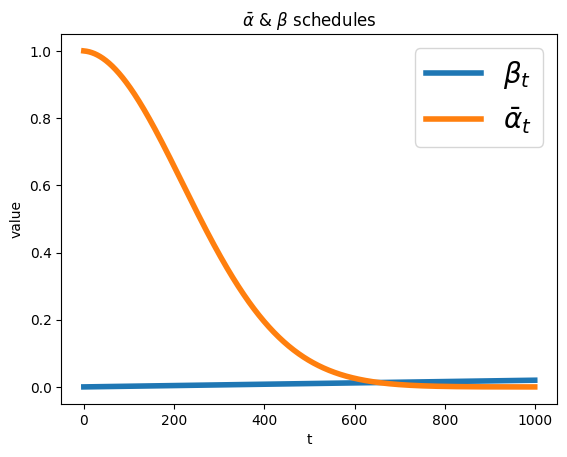

In [2]:
# beta schedules
def beta_schedule(t, beta0, beta1, T):
    return beta0 + (beta1 - beta0) * t / T

# alpha_t = 1 - beta_t
# alpha_bar_t = cumulative product of alpha_t
def alpha_bar(beta0, beta1, T):
    alpha_bar = []
    for t in range(T):
        alpha_t = 1 - beta_schedule(t, beta0, beta1, T)
        if t == 0:
            alpha_bar_t = alpha_t
        else:
            alpha_bar_t = alpha_bar_t * alpha_t
        alpha_bar.append(alpha_bar_t)
    return alpha_bar

# plot beta schedules: 0.0001 -> 0.02, T=1000
T = 1000
t = np.arange(T)
beta0 = 0.0001
beta1 = 0.02
plt.plot(t, beta_schedule(t, beta0, beta1, T), lw=4, label=r'$\beta_t$')
plt.plot(t, alpha_bar(beta0, beta1, T), lw=4, label=r'$\bar{\alpha}_t$')
plt.xlabel('t')
plt.ylabel('value')
plt.title(r'$\bar{\alpha}$ & $\beta$ schedules')
plt.legend(fontsize=20)
plt.show()

### Naive forward implementation

$$x_{t} = \sqrt{1-\beta_t} x_{t-1} + \sqrt{\beta_t} \mathcal{N}(0, \mathbb{I})$$

0it [00:00, ?it/s]
100%|██████████| 999/999 [00:48<00:00, 20.54it/s]


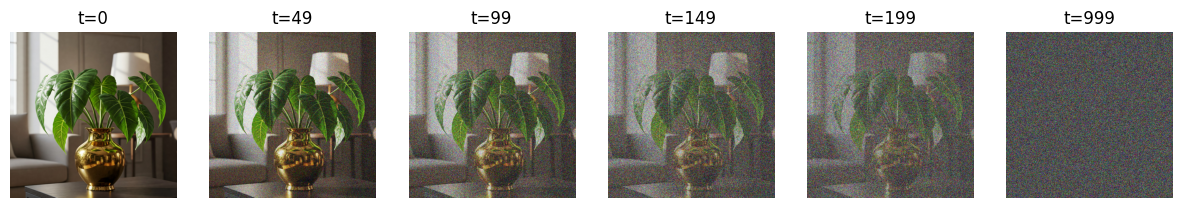

In [3]:
from tqdm import tqdm

def naive_forward(image, timestep, beta_t):
    # forward pass
    x = image
    for t in tqdm(range(timestep)):
        eps = np.random.randn(*x.shape)
        x = np.sqrt(1 - beta_t) * x + np.sqrt(beta_t) * eps
    return x


# Visualization of the forward process
def visualize_forward_process(noised_images):
    """
    Visualize the progression of the forward diffusion process.
    """
    n = len(noised_images)
    fig, axes = plt.subplots(1, n, figsize=(15, 10))
    for i, (t, img) in enumerate(noised_images):
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"t={t}")
        axes[i].axis("off")
    plt.show()


beta_min, beta_max = 0.0001, 0.02
total_steps = 1000
betas = np.linspace(beta_min, beta_max, total_steps)  # Linear schedule

image = Image.open('images/plant.jpg').convert('RGB')
image = np.array(image).astype(np.float32) / 255
image = resize(image, (1024, 1024), anti_aliasing=True)
noised_images = []
for i, timestep in enumerate([0, 49, 99, 149, 199, 999]):
    noised_image = naive_forward(
        image.copy(), timestep, beta_t=betas[timestep]
    )
    noised_images.append((timestep, noised_image))

visualize_forward_process(noised_images)

### Fast-forward: Directly jump to step $t$


$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon$$

In [4]:
# Define the forward diffusion process
# directly jump to the timestep you want to see
def forward_diffusion(image, alpha_bar_t):
    """
    Add noise to the image over timesteps
    following a diffusion schedule.
    """
    noise = np.random.normal(0, 1, image.shape)
    noised_image = np.sqrt(alpha_bar_t) * image + np.sqrt(1 - alpha_bar_t) * noise
    return noised_image


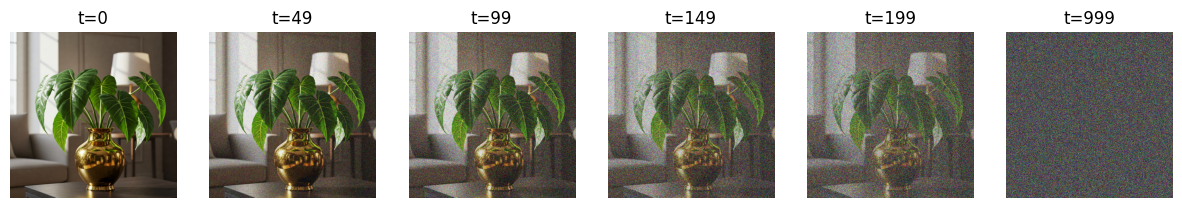

In [5]:
image = Image.open("images/plant.jpg")
image = np.asarray(image).astype(np.float32) / 255
image = resize(image, (1024, 1024), anti_aliasing=True)

total_steps = 1000  # Number of diffusion steps
beta_min, beta_max = 0.0001, 0.02
betas = np.linspace(beta_min, beta_max, total_steps)  # Linear schedule
alphas = 1 - betas
alphas_cumprod = np.cumprod(alphas)



noised_images = [(0, image.copy())]
for t in [49, 99, 149, 199, 999]:
    noised_image = forward_diffusion(
        image.copy(), alphas_cumprod[t]
    )
    noised_images.append((t, noised_image))

# Visualize forward process
visualize_forward_process(noised_images)

#### Actual noise


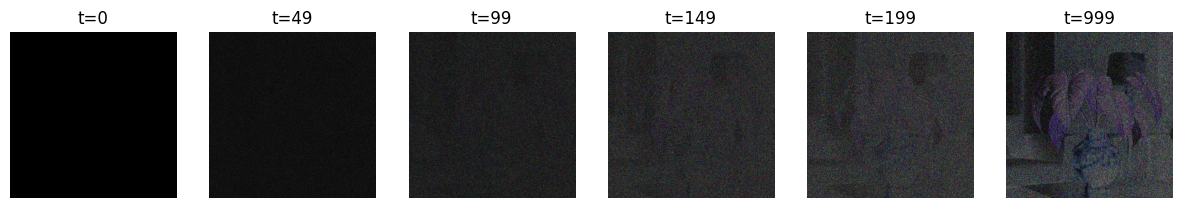

In [8]:
noise_added = [(t, img - image) for t, img in noised_images]
visualize_forward_process(noise_added)

<img src="images/training.png" alt="training" width="400"/>

### Reverse process

* Reverse: $$x_T \rightarrow x_{T-1} \rightarrow  ... \rightarrow x_0$$

---

$$q(x_{t-1}|x_{t})=\mathcal{N}\left(x_{t-1}; \mu_q, \Sigma_q\right)$$

$$p_\theta(x_{t-1}|x_t)\rightarrow \mathcal{N}\left(x_{t-1}; \mu_\theta, \Sigma_\theta\right)$$


$$\mu_\theta = \frac{x_t}{\sqrt{\alpha_t}} - \frac{(1-\alpha_t)\sqrt{1-\bar{\alpha}_t}}{(1-\bar{\alpha}_t)\sqrt{\bar{\alpha}_t}}\epsilon_\theta$$

$$\Sigma_\theta(t) = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t} \mathbb{I}$$






* Joint distribution of the reverse process

$$p_\theta(x_{0..T})=p_\theta(x_T)\prod_{t=1}^T p_\theta(x_{t-1}|x_t)$$

where $p_\theta(x_T)\sim \mathcal{N}(0,\mathbb{I})$

----
### Objective: maximize the likelihood of data

$$p_\theta(x_0)=\int p_\theta(x_0,x_{1..T}) d_{x_{1..T}}$$

* Evidence Lower-Bound (ELBo) of the likelihood:
$$p_\theta(x_0) \ge \mathbb{E}_{q(x_{1..T}|x_0)} \left[\log p_\theta (x_0|x_{1..T})\right] - D_{KL}\left(q(x_{1..T}|x_0)\|p_\theta(x_{1..T})\right)$$

* Expanding the second term ($D_{KL}$ term)

$$D_{KL}\left(q(x_{1..T}|x_0)\|p_\theta(x_{1..T})\right) = \int q(x_{1..T} \frac{q(x_{1..T}}{p_\theta(x_{1..T})} d_{x_{1..T}}$$

$$ = E_{q(x_{1..T}|x_0)}\left[\log \frac{q(x_{1..T}|x_0)}{p_\theta(x_{1..T})}\right]$$

* Rewrite the ELBo to merge the two terms

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_0|x_{1..T}) - \log \frac{q(x_{1..T}|x_0)}{p_\theta(x_{1..T})}\right]$$

* Inverse the fravtion

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_0|x_{1..T}) + \log \frac{p_\theta(x_{1..T})}{q(x_{1..T}|x_0)}\right]$$

* Combine the two $\log$ terms: $\log(a) + \log(b) = \log(ab)$

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log \frac{p_\theta(x_{1..T}) p_\theta (x_0|x_{1..T})}{q(x_{1..T}|x_0)}\right]$$

* Rewrite to joint distribution
$p(a,b) = p(a)p(b|a) = p(b) p(a|b)$

$$\Rightarrow p_\theta(x_{1..T}) p_\theta (x_0|x_{1..T}) = p_\theta (x_{1..T})$$

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log \frac{p_\theta (x_{0..T})}{q(x_{1..T}|x_0)}\right]$$

#### Expand the ELBo again 


$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log \frac{p_\theta (x_{0..T})}{q(x_{1..T}|x_0)}\right]$$

$$ = E_{q(x_{1..T}|x_0)}\left[\log \frac{p_\theta (x_{T}) \prod_{t=1}^T p_\theta(x_{t-1}|x_t)}{q(x_{1..T}|x_0)}\right]$$

* Use the log rul: $\log(\frac{ab}{c})=\log(a)+\log(b)-\log(c)$

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T})\right] \\ + E_{q(x_{1..T}|x_0)}\left[ \log \prod_{t=1}^T p_\theta(x_{t-1}|x_t)\right] \\ - E_{q(x_{1..T}|x_0)}\left[\log q(x_{1..T}|x_0)\right]$$


* Move the product term outside $\log$: (product becomes sum)
$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T})\right] \\ + \sum_{t=1}^T E_{q(x_{1..T}|x_0)}\left[ \log p_\theta(x_{t-1}|x_t)\right] \\ - E_{q(x_{1..T}|x_0)}\left[\log q(x_{1..T}|x_0)\right]$$

* Exapnd the 3rd term

$$Term3 = E_{q(x_{1..T}|x_0)}\left[\log q(x_{1..T}|x_0)\right]$$

$$ = E_{q(x_{1..T}|x_0)}\left[\log \prod_{t=1}^T q(x_t|x_{t-1})\right]$$

$$ = \sum_{t=1}^T E_{q(x_{1..T}|x_0)}\left[\log  q(x_t|x_{t-1})\right]$$

* Rewrite ELBo combineing Term2 & term3

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T})\right] + \sum_{t=1}^T E_{q(x_{1..T}|x_0)}\left[ \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t}|x_{t-1})}\right] $$

The new term (second term above):
$\sum_{t=1}^T E_{q(x_{1..T}|x_0)}\left[ \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t}|x_{t-1})}\right]$ $\Longrightarrow $ KL-div between the forward and reverse processes

----
### First variant of objective function

$$ \mathcal{L}(x_0) = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T})\right] + \sum_{t=1}^T E_{q(x_{1..T}|x_0)}\left[ \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t}|x_{t-1})}\right] $$

-----

#### Simplifying the objective

* Bayes rule: $P(A|B)=\frac{P(B|A) P(A)}{P(B)}$

$$q(x_t|x_{t-1}) = \frac{q(x_{t-1}|x_{t}) q(x_t)}{q(x_{t-1})}$$


* Markov property:
$$q(x_t|x_{t-1}) = q(x_t|x_{t-1}, x_0)$$

* Combine (add $x_0$ to all as a given condition)
$$q(x_t|x_{t-1}, x_0) = \frac{q(x_{t-1}|x_{t}, x_0) q(x_t|x_0)}{q(x_{t-1}|x_0)}$$

##### Plug this into the objective function

$$ \mathcal{L}(x_0) = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T})\right] + \sum_{t=1}^T E_{q(x_{1..T}|x_0)}\left[ \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t}|x_{t-1})}\right] $$

$$ = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T})\right] + \sum_{t=2}^T E_{q(x_{1..T}|x_0)}\left[ \log \frac{p_\theta(x_{t-1}|x_t)}{\frac{q(x_{t-1}|x_{t}, x_0) q(x_t|x_0)}{q(x_{t-1}|x_0)}}\right] + E_{q(x_{1..T}|x_0)}\left[\frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}\right]$$

$$ = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T}) \\ + \sum_{t=2}^T  \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_{t},x_0)} \\ + \sum_{t=2}^T  \log \frac{q(x_{t-1}|x_0)}{q(x_{t}|x_0)} + \log \frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}\right]$$

* The third term is a collescopic term

$$Term3 = \sum_{t=2}^T  \log \frac{q(x_{t-1}|x_0)}{q(x_{t}|x_0)} $$

$$ = \log \frac{q(x_{1}|x_0)}{q(x_{2}|x_0)} + \log \frac{q(x_{2}|x_0)}{q(x_{3}|x_0)} + ... + \log \frac{q(x_{T-2}|x_0)}{q(x_{T-1}|x_0)} + \log \frac{q(x_{T-1}|x_0)}{q(x_{T}|x_0)} $$

Lots of terms will cancel out:

$$ = \log \frac{q(x_{1}|x_0)}{\cancel{q(x_{2}|x_0)}} + \log \frac{\cancel{q(x_{2}|x_0)}}{\cancel{q(x_{3}|x_0)}} + ... + \log \frac{\cancel{q(x_{T-2}|x_0)}}{\cancel{q(x_{T-1}|x_0)}} + \log \frac{\cancel{q(x_{T-1}|x_0)}}{q(x_{T}|x_0)} $$

$$ = \log \frac{q(x_{1}|x_0)}{q(x_{T}|x_0)} $$

* Updating the ELBo:

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T}) \\ + \sum_{t=2}^T  \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_{t},x_0)} \\ + \log \frac{q(x_{1}|x_0)}{q(x_{T}|x_0)} + \log \frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}\right]$$

$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log p_\theta (x_{T}) \\ + \sum_{t=2}^T  \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_{t},x_0)} \\ + \log \frac{\cancel{q(x_{1}|x_0)}}{q(x_{T}|x_0)} + \log \frac{p_\theta(x_0|x_1)}{\cancel{q(x_1|x_0)}}\right]$$

Rewrite:
$$ ELBo = E_{q(x_{1..T}|x_0)}\left[\log \frac{p_\theta (x_{T})}{q(x_{T}|x_0)} \\ + \sum_{t=2}^T  \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_{t},x_0)} \\ + \log p_\theta(x_0|x_1)\right]$$

* The first term becomes the KL-div of $q(x_T|x_0)$ and $p_\theta (x_T)$
  (maybe I missed a negative sign somewhere)
    $$D_{KL}\left[q(x_T|x_0)\| p_\theta (x_T)\right]$$


* The second term becomes the KL-div of $q(x_{t-1}|x_0)$ and $p_\theta (x_{t-1}|x_t)$

$$\sum_{t=2}^T  E_{q(x_{1..T}|x_0)} D_{KL} \left[q(x_{t-1}|x_{t},x_0) \| p_\theta(x_{t-1}|x_t)\right]$$

$\Rightarrow$ KL-div between $q$ & $p_\theta$

$\mu_\theta + \sigma_t z \rightarrow x_{T-1}$